In this notebook, we will build a 3D map of a scene from a small set of images and refine it with the featuremetric optimization. We then localize an image downloaded from the Internet and show the effect of the refinement.

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import os
import time

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap, plot_reconstruction_minus_camera


from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect
from PIL import Image, ImageDraw
# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

# Setup
We start by defining some output paths: where the intermediate files will be stored.

In [2]:
images = Path('datasets/monarch/')
outputs = Path('outputs/monarch-demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
raw_dir = outputs / "raw"
ref_dir = outputs / "ref"

Here we will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [3]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping and refinement
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

In [4]:
'''masking of the tractor hood from the images '''
''' output => datasets/monarch/{target_folder}/image_name.jpg '''
def draw_box_around_tractor_hood(image_path, target_folder): 
    image = Image.open(image_path)
    w, h = image.size
    box_x1, box_y1 = 460, 770  # Top-left corner
    box_x2, box_y2 = 1630, 1080  # Bottom-right corner
    outline_color = (0, 0, 0)  # Red in RGB format
    fill_color = (0, 0, 0)  # Black in RGB format
    draw = ImageDraw.Draw(image)
    draw.rectangle([box_x1, box_y1, box_x2, box_y2], outline=outline_color, fill=fill_color)
    directory_path,filename = os.path.split(image_path)
    parent_directory_path = os.path.dirname(directory_path)
    target_directory = os.path.join(parent_directory_path, target_folder)
    os.makedirs(target_directory, exist_ok = True)
    target_image_path = os.path.join(target_directory,filename)
    image.save(target_image_path)
    return target_image_path 

In [5]:
references = [str(p) for i, p in enumerate((images / 'mapping/').iterdir())]
print(f"references: {references[0:5]}")

references: ['datasets/monarch/mapping/495_left.jpg', 'datasets/monarch/mapping/410_left.jpg', 'datasets/monarch/mapping/479_left.jpg', 'datasets/monarch/mapping/60_left.jpg', 'datasets/monarch/mapping/423_left.jpg']


In [6]:
''' masking the tractor hood in all the images'''
''' returns list of path to the masked images '''
start_time = time.time()
target_folder = "masked_images"
masked_references = [draw_box_around_tractor_hood(p, target_folder) for p in references]
end_time = time.time()
elapsed_time = end_time - start_time

target_path = os.path.join(images, target_folder)

''' sorting masked_references sequentially '''
''' smf => sorted masked references '''
smf = sorted(masked_references, key = lambda x: int(((x.split("/")[-1]).split(".")[0]).split("_")[0]))

In [7]:
''' trimming the dataset '''
''' t_smf => trimmed sorted mask references '''
t_smf = smf[100:200]
''' relative to images '''
''' rsmf => relative sorted mask references '''
r_smf = [str(Path(p).relative_to(images)) for p in t_smf]
'''updating references '''
references = r_smf[0:20]

In [22]:
print(references)

['masked_images/100_left.jpg', 'masked_images/101_left.jpg', 'masked_images/102_left.jpg', 'masked_images/103_left.jpg', 'masked_images/104_left.jpg', 'masked_images/105_left.jpg', 'masked_images/106_left.jpg', 'masked_images/107_left.jpg', 'masked_images/108_left.jpg', 'masked_images/109_left.jpg', 'masked_images/110_left.jpg', 'masked_images/111_left.jpg', 'masked_images/112_left.jpg', 'masked_images/113_left.jpg', 'masked_images/114_left.jpg', 'masked_images/115_left.jpg', 'masked_images/116_left.jpg', 'masked_images/117_left.jpg', 'masked_images/118_left.jpg', 'masked_images/119_left.jpg']


Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively.

In [8]:
features_path_ = extract_features.main(feature_conf, images, image_list=references, feature_path=features)
#match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/11/04 15:28:10 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/20 [00:00<?, ?it/s]

[2023/11/04 15:28:12 hloc INFO] Finished exporting features.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
current_path:  /home/skumar/pixel-perfect-sfm
<class 'str'>


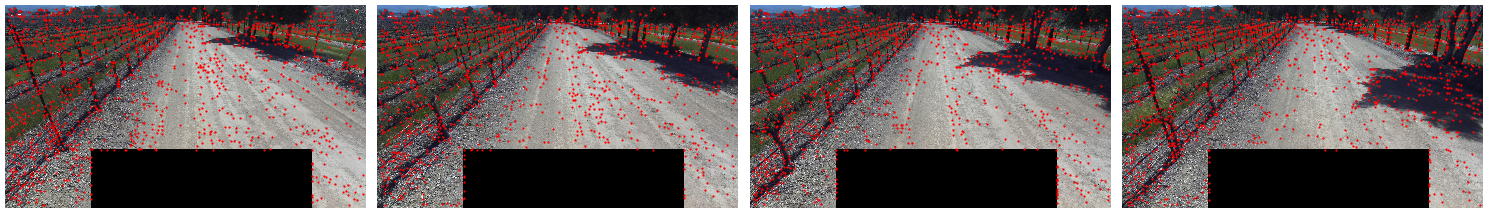

In [9]:
from hloc.utils.viz import plot_keypoints, save_plot
from hloc.utils.io import get_keypoints
import matplotlib.pyplot as plt
import numpy as np
import os

ref_trim_ = references[:4]
plot_images([read_image(images / r) for r in ref_trim_], dpi=50, figsize=4.2)

kps_list_ = [] 
for r in ref_trim_:
    kps = get_keypoints(features_path_, r)
    print(type(kps))
    kps_list_.append(kps)
    
plot_keypoints(kps_list_, colors = "red",  ps = 10)

current_path_ = os.getcwd()

print("current_path: ", current_path_)

print(type(current_path_))

final_path = current_path_ + "/kps.png"


save_plot(final_path)


In [10]:
pairs_from_exhaustive.sequential_main(sfm_pairs, image_list=references)

[2023/11/04 15:28:13 hloc INFO] Found 70 pairs.


In [11]:
#print("features: ", features)
#print("matches: ", matches)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/11/04 15:28:13 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/70 [00:00<?, ?it/s]

[2023/11/04 15:28:18 hloc INFO] Finished exporting matches.


Now we run the reconstruction with and without the featuremetric refinement. For this dataset, when computing the dense features, we resize the images such that they are not larger than 1024 pixels.

In [12]:
fx = 1093.2768
fy = 1093.2768
cx = 964.989
cy = 569.276
opencv_camera_params =','.join(map(str, (fx, fy, cx, cy, 0, 0, 0, 0)))

In [17]:
sfm = PixSfM({"dense_features": {"max_edge": 1024}})

[2023/11/04 15:30:45 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /home/skumar/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2023/11/04 15:30:45 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1024,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


In [ ]:
image_options = dict(camera_model='OPENCV', 
                    camera_params=opencv_camera_params,
                    )
mapper_options = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False)
hloc_args = dict(image_list=references,
                image_options=image_options,
                camera_mode="PER_FOLDER")
hloc_args_locked = dict(image_list=references,
                image_options=image_options,
                 mapper_options=mapper_options,
                camera_mode="PER_FOLDER")
K_locked, sfm_outputs_locked = sfm.reconstruction(ref_dir, images, sfm_pairs, features, matches, **hloc_args)
K_not_locked, sfm_outputs_not_locked = sfm.reconstruction(ref_dir, images, sfm_pairs, features, matches, **hloc_args_locked)


[2023/11/04 15:47:08 pixsfm INFO] Building matching graph...
[2023/11/04 15:47:08 pixsfm INFO] Extracting dense features...


  0%|          | 0/20 [00:00<?, ?it/s]

[2023/11/04 15:47:15 pixsfm INFO] Computing tracks...
[2023/11/04 15:47:15 pixsfm INFO] # graph nodes: 15922
[2023/11/04 15:47:15 pixsfm INFO] # graph edges: 23308
[2023/11/04 15:47:15 pixsfm INFO] # tracks: 4079
[2023/11/04 15:47:15 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 15922/15922 [00:02, 7333.94it/s]


[2023/11/04 15:47:17 pixsfm INFO] KA Time: 2.17184s, cost change: 0.0209949 --> 0.0191238


[2023/11/04 15:47:17 hloc WARNING] The database already exists, deleting it.
[2023/11/04 15:47:17 hloc INFO] Creating an empty database...
[2023/11/04 15:47:17 hloc INFO] Importing images into the database...
[2023/11/04 15:47:17 hloc INFO] Importing features into the database...


  0%|          | 0/20 [00:00<?, ?it/s]

[2023/11/04 15:47:17 hloc INFO] Importing matches into the database...


  0%|          | 0/70 [00:00<?, ?it/s]

[2023/11/04 15:47:17 hloc INFO] Performing geometric verification of the matches...
[2023/11/04 15:47:19 hloc INFO] Running 3D reconstruction...
[2023/11/04 15:47:45 hloc INFO] Reconstructed 1 model(s).
[2023/11/04 15:47:45 hloc INFO] Largest model is #0 with 20 images.
[2023/11/04 15:47:45 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 20
	num_cameras = 1
	num_points3D = 1750
	num_observations = 5364
	mean_track_length = 3.06514
	mean_observations_per_image = 268.2
	mean_reprojection_error = 0.997684
	num_input_images = 20


[2023/11/04 15:47:45 pixsfm INFO] Extracting references.


100%[████████████████████] 1750/1750 [00:00, 11986.3it/s]


[2023/11/04 15:47:45 pixsfm INFO] Reference Extraction Time: 0.151886s
[2023/11/04 15:47:45 pixsfm INFO] Start feature-reference bundle adjustment.


100%[████████████████████] 101/101 [00:06, 15.4884it/s]


[2023/11/04 15:47:52 pixsfm INFO] BA Time: 6.52159s, cost change: 0.0198275 --> 0.0194781


[2023/11/04 15:47:52 pixsfm INFO] Building matching graph...
[2023/11/04 15:47:52 pixsfm INFO] Extracting dense features...


  0%|          | 0/20 [00:00<?, ?it/s]

[2023/11/04 15:48:00 pixsfm INFO] Computing tracks...
[2023/11/04 15:48:00 pixsfm INFO] # graph nodes: 15922
[2023/11/04 15:48:00 pixsfm INFO] # graph edges: 23308
[2023/11/04 15:48:00 pixsfm INFO] # tracks: 4079
[2023/11/04 15:48:00 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 15922/15922 [00:01, 11917.6it/s]


[2023/11/04 15:48:01 pixsfm INFO] KA Time: 1.33675s, cost change: 0.0209949 --> 0.0191238


[2023/11/04 15:48:01 hloc WARNING] The database already exists, deleting it.
[2023/11/04 15:48:01 hloc INFO] Creating an empty database...
[2023/11/04 15:48:01 hloc INFO] Importing images into the database...
[2023/11/04 15:48:01 hloc INFO] Importing features into the database...


  0%|          | 0/20 [00:00<?, ?it/s]

[2023/11/04 15:48:01 hloc INFO] Importing matches into the database...


  0%|          | 0/70 [00:00<?, ?it/s]

[2023/11/04 15:48:01 hloc INFO] Performing geometric verification of the matches...
[2023/11/04 15:48:02 hloc INFO] Running 3D reconstruction...


In [25]:
#refined, sfm_outputs = sfm.reconstruction(ref_dir, images, sfm_pairs, features, matches, image_list=references)
#refined, sfm_outputs = sfm.reconstruction(ref_dir, images, sfm_pairs, features, matches, **hloc_args)


In [ ]:
# run pixsfm
#sfm = PixSfM({"dense_features": {"max_edge": 1024}})
#refined, sfm_outputs = sfm.reconstruction(ref_dir, images, sfm_pairs, features, matches, image_list=references)

# here ref is pycolmap.Reconstruction object

# run the raw geometric SfM for comparison
#raw_sfm = PixSfM({"KA":{"apply": False}, "BA": {"apply": False}})
#raw, _ = raw_sfm.reconstruction(raw_dir, images, sfm_pairs, features, matches, image_list=references)

In [ ]:
print(dir(refined))

In [ ]:
from itertools import islice
print(dir(refined.cameras))
#print(refined.cameras)
for key, value in islice(refined.cameras.items(), 5):
    print(f"key: {key}")
    #print(dir(value))
    #print(f"type(value): {type(value)} value: {value}")
    print(f"camera: {value.calibration_matrix()}")

`refined` and `raw` are `pycolmap.Reconstruction` objects, of which we can print the statistics to compare them:

In [ ]:
#print("Raw", raw.summary())
#print("Refined", refined.summary())

In [ ]:
#print(dir(raw))

In [ ]:
#raw.num_points3D

In [ ]:
#refined.export_PLY("refined_pointcloud.ply")

# Visualization
To visualize both models together, we rigidly transform the raw reconstruction so that the 3D points common to the two 3D models are aligned.

In [ ]:
#raw.align_points(refined, max_error=0.05, min_inlier_ratio=0.6, min_overlap=3)

We now plot the reconstructions side-by-side. We can click on the legend entries to toggle them.

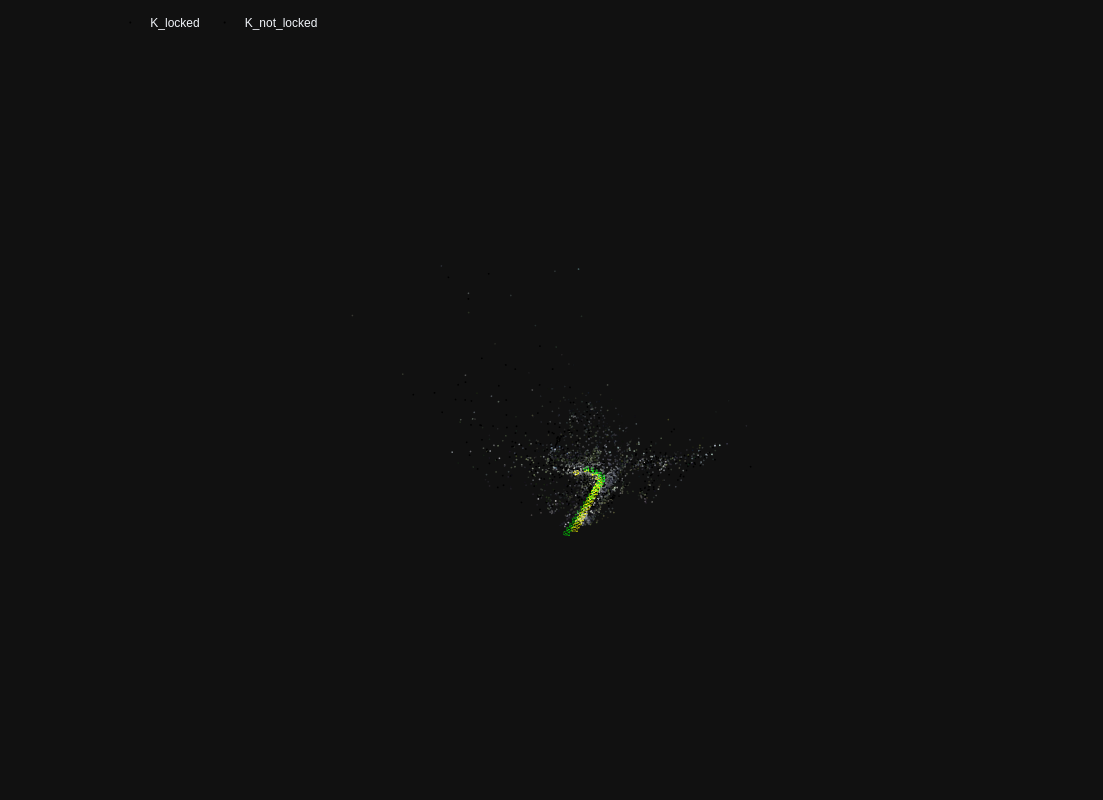

In [29]:
fig3d = init_figure()
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)
plot_reconstruction(fig3d, K_locked, color='rgba(0, 255, 0, 0.5)', name="K_locked", **args)
plot_reconstruction(fig3d, K_not_locked, color='rgba(255, 255, 0, 0.5)', name="K_not_locked", **args)

fig3d.show()

In [27]:
#fig3d = init_figure()
#rgs = dict(max_reproj_error=3.0, min_track_length=2, cs=1)
#plot_reconstruction(fig3d, raw, color='rgba(255, 0, 0, 0.5)', name="raw", **args)
#plot_reconstruction_minus_camera(fig3d, refined, color='rgba(0, 255, 0, 0.5)', name="refined", **args)
#plot_reconstruction(fig3d, refined, color='rgba(0, 255, 0, 0.5)', name="refined_with_camera", **args)

#fig3d.show()

We can also visualize the detected keypoints (blue) and the final reprojections (red) for a given mapping image. You can drag to zoom in. As you can see, the points were refined by a few pixels at most but the 3D points and camera poses can be refined up to a few meters.

In [ ]:
img = refined.images[refined.reg_image_ids()[0]]
cam = refined.cameras[img.camera_id]
fig = init_image(images / img.name)    
plot_points2D(fig, [p2D.xy for p2D in img.points2D if p2D.has_point3D()])
plot_points2D(fig, cam.world_to_image(img.project(refined)), color='rgba(255, 0, 0, 0.5)')
fig.show()

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/c/c0/La_basilique_du_Sacr%C3%A9-Coeur_au_cr%C3%A9puscule_%28Paris%29_%284147593805%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [ ]:
references_registered = [refined.images[i].name for i in refined.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters. Under the hood, the `QueryLocalizer` takes care of extracting dense features for the query and runs the keypoint and pose adjustments, QKA and QBA. The refinement refines the camera parameters in-place so we can inspect them.

In [ ]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [refined.find_image_with_name(r).image_id for r in references_registered]
conf = {
    "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
    "PnP": {  # initial pose estimation with PnP+RANSAC
        'estimation': {'ransac': {'max_error': 12.0}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    },
    "QBA": {  # query pose refinement
        "optimizer:": {'refine_focal_length': True, 'refine_extra_params': True},
    }
}
dense_features = sfm_outputs["feature_manager"]
localizer = QueryLocalizer(refined, conf, dense_features=dense_features)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches, image_path=images/query)

print(f'found {sum(ret["inliers"])}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, refined, top_k_db=1)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map, shown here in blue.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
plot_camera_colmap(fig3d, pose, camera, color='rgba(128,128,255,0.5)', name=query, legendgroup="refined")
fig3d.show()